In [19]:
# Import des librairies
import numpy as np
import typing
import pandas as pd
from typing import Any, Tuple
import tensorflow as tf
import tensorflow_text as tf_text
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [20]:
# Téchargement de la base d'apprentissage
import pathlib

path_to_zip = tf.keras.utils.get_file(
    'fra-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/fra-eng.zip',
    extract=True)

#path_to_file = pathlib.Path(path_to_zip).parent/'fra.txt'
path_to_file = pathlib.Path('mini_base_donnees_3.txt')


In [21]:
# Extraction des entrées et sortie cibles  du modèles 
def load_data(path):
    text = path.read_text(encoding='utf-8')
    lines = text.splitlines()
    pairs = [line.split('\t') for line in lines]
    inp = [inp for targ, inp in pairs]
    targ = [targ for targ, inp in pairs]

    return targ, inp

In [22]:
targ, inp = load_data(path_to_file)

Lang_pairs = {'Source':inp,'Target':targ}
df = pd.DataFrame(Lang_pairs)
pd.set_option('max_colwidth', 800)
df.head()

,Source,Target
0,"L'année dernière, je vous ai présenté ces deux diapositives qui montraient que la calotte glacière arctique, qui pendant ces 3 derniers millions d'année avait la taille des Etats-Unis sans l'Alaska, qui pendant ces 3 derniers millions d'année avait la taille des Etats-Unis sans l'Alaska, avait diminué de 40%.","Last year I showed these two slides so that demonstrate that the arctic ice cap, which for most of the last three million years has been the size of the lower 48 states, has shrunk by 40 percent."
1,Mais ceci tend à amoindrir le problème parce qu'on ne voit pas l'épaisseur de la glace.,But this understates the seriousness of this particular problem because it doesn't show the thickness of the ice.
2,On peut voir la calotte glacière arctique comme le coeur du système climatique global. On peut voir la calotte glacière arctique comme le coeur du système climatique global.,"The arctic ice cap is, in a sense, the beating heart of the global climate system."
3,Elle s'étend en hiver et se contracte en été.,It expands in winter and contracts in summer.
4,La prochaine diapositive que je vais vous montrer est une vue en accéléré de ce qui s'est passé ces 25 dernières années.,The next slide I show you will be a rapid fast-forward of what's happened over the last 25 years.


In [23]:
# Taille des données d'entrée
print("Nombre de phrases contenus dans les données : ", len(inp))
# On entraine sur 167130 phrase avec des longueur variable allant des plus petites au plus longues

# pour montrer qu'on a des longueurs différentes
taille_input = [len(p) for p in inp]
print("Nombre de mots de la plus petite phrase : ", min(taille_input))
print("Nombre de mots de la plus longue phrase : ", max(taille_input))

Nombre de phrases contenus dans les données :  890
Nombre de mots de la plus petite phrase :  10
Nombre de mots de la plus longue phrase :  497


In [24]:
BUFFER_SIZE = len(inp)
BATCH_SIZE = 64
print("Si on prend toutes les données on aura",round(BUFFER_SIZE/BATCH_SIZE), "exemples pour chaque epoque")

Si on prend toutes les données on aura 14 exemples pour chaque epoque


In [25]:
# on mélange les données pour ne pas avoir que des phrases de même longueur
# pour un entrainement plus léger on peut limiter les données en entrée à (inp[:50000], targ[:50000]) 
dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [26]:
for example_input_batch, example_target_batch in dataset.take(1):
    print(example_input_batch[:5])
    print()
    print(example_target_batch[:5])
    break  

tf.Tensor(
[b"  Elle s'\xc3\xa9tend en hiver et se contracte en \xc3\xa9t\xc3\xa9.  "
 b'  Nos magasines sont lus par des millions de personnes.  '
 b'  Voil\xc3\xa0 notre plus jeune b\xc3\xaata testeur, en bas \xc3\xa0 droite.  '
 b"  Je suis convaincu que nous avons d\xc3\xa9pass\xc3\xa9 cette limite du nombre d'options qui augmentent notre bien \xc3\xaatre.  "
 b'  Il a commenc\xc3\xa9 \xc3\xa0 sentir la vieille angoisse monter en lui ce : \xc2\xab Je vais la perdre et je vais \xc3\xaatre hant\xc3\xa9 par cette chanson \xc3\xa0 tout jamais.  '], shape=(5,), dtype=string)

tf.Tensor(
[b' It expands in winter and contracts in summer.    '
 b' Our magazines are read by millions.    '
 b" That's our youngest beta tester, down there on the right.    "
 b" I'm pretty confident that we have long since passed the point  where options improve our welfare.    "
 b' So he starts to feel all of that old anxiety start to rise in him  like, "I\'m going to lose this thing,  and I\'ll be be haunted

In [27]:
# On a des problème ou y'a des accents, il faut travailler en unicode, on normalise en montrant d'abord la lettre
# La normalisation Unicode pour diviser les caractères accentués et remplacer les caractères de compatibilité par leurs équivalents ASCII.
example_text = tf.constant('Où étais-tu passé?')

#print(example_text.numpy())
print("Où étais-tu passé?  ---> ", tf_text.normalize_utf8(example_text, 'NFKD').numpy())

Où étais-tu passé?  --->  b'Ou\xcc\x80 e\xcc\x81tais-tu passe\xcc\x81?'


In [28]:
def tf_lower_and_split_punct(text):
    # Split accecented characters.
    text = tf_text.normalize_utf8(text, 'NFKD')
    
    text = tf.strings.lower(text)
    # Keep space, a to z, and select punctuation.
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿-]', '')
    # Replace Hyphen with a space 
    text = tf.strings.regex_replace(text, '[-]', ' ')
    # Add spaces around punctuation.
    text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
    # Strip whitespace.
    text = tf.strings.strip(text)
    # on ajoute des indicateurs de début et fin de phrase
    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text

In [29]:
print(example_text.numpy().decode())
# on garde que la lettre sans accent
print(tf_lower_and_split_punct(example_text).numpy().decode())

Où étais-tu passé?
[START] ou etais tu passe ? [END]


In [30]:
max_vocab_size = 5000

# We use TextVectorization to map text features to integer sequences
input_text_processor = tf.keras.layers.TextVectorization(standardize=tf_lower_and_split_punct, max_tokens=max_vocab_size)
output_text_processor = tf.keras.layers.TextVectorization( standardize=tf_lower_and_split_punct,max_tokens=max_vocab_size)

input_text_processor.adapt(inp)
output_text_processor.adapt(targ)

out = output_text_processor.get_vocabulary()[:10]
inpt = input_text_processor.get_vocabulary()[:10]

print(f"Source Vocabulary size :{input_text_processor.vocabulary_size()} words")
print(f"Target Vocabulary size :{output_text_processor.vocabulary_size()} words ")
print("-"*35)

print(f"Source Vocab samples : {inpt}\nTarget Vocab samples : {out}")

Source Vocabulary size :3734 words
Target Vocabulary size :3157 words 
-----------------------------------
Source Vocab samples : ['', '[UNK]', ',', '.', '[START]', '[END]', 'de', 'a', 'la', 'et']
Target Vocab samples : ['', '[UNK]', ',', 'the', '[START]', '[END]', '.', 'of', 'and', 'to']


In [31]:
"""
max_vocab_size = 5000

input_text_processor = tf.keras.layers.TextVectorization(standardize=tf_lower_and_split_punct, max_tokens=max_vocab_size)

input_text_processor.adapt(inp)
# Les 10 premiers mot de notre vocabulaire d'entrée:
input_text_processor.get_vocabulary()[:10]
"""

"\nmax_vocab_size = 5000\n\ninput_text_processor = tf.keras.layers.TextVectorization(standardize=tf_lower_and_split_punct, max_tokens=max_vocab_size)\n\ninput_text_processor.adapt(inp)\n# Les 10 premiers mot de notre vocabulaire d'entrée:\ninput_text_processor.get_vocabulary()[:10]\n"

In [32]:
"""
output_text_processor = tf.keras.layers.TextVectorization( standardize=tf_lower_and_split_punct,max_tokens=max_vocab_size)
output_text_processor.adapt(targ)
# Les 10 premiers mot de notre vocabulaire de sortie:
output_text_processor.get_vocabulary()[:10]
"""

'\noutput_text_processor = tf.keras.layers.TextVectorization( standardize=tf_lower_and_split_punct,max_tokens=max_vocab_size)\noutput_text_processor.adapt(targ)\n# Les 10 premiers mot de notre vocabulaire de sortie:\noutput_text_processor.get_vocabulary()[:10]\n'

In [40]:
example_tokens = input_text_processor(example_input_batch)
print(example_input_batch[:1])
# quelques phrases tokenisées
example_tokens[:1,:12]

tf.Tensor([b"  Elle s'\xc3\xa9tend en hiver et se contracte en \xc3\xa9t\xc3\xa9.  "], shape=(1,), dtype=string)


<tf.Tensor: shape=(1, 12), dtype=int64, numpy=
array([[   4,   62, 1759,   16, 1209,    9,   50, 3325,   16,   67,    3,
           5]])>

In [34]:
# La get_vocabulary méthode peut être utilisée pour convertir les ID de jeton retour au texte:
input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] elle setend en hiver et se contracte en ete . [END]                                                         '

Text(0.5, 1.0, 'Mask')

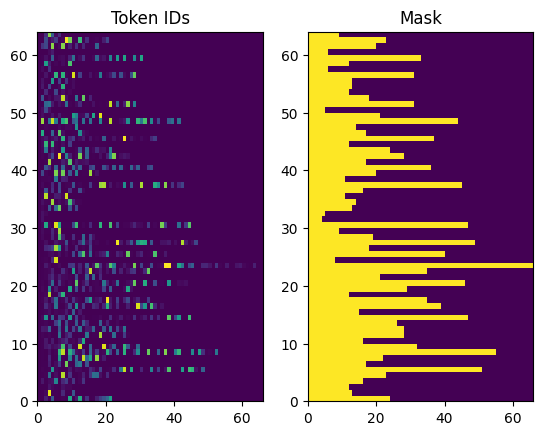

In [17]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens)
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

tf.Tensor([64], shape=(1,), dtype=int32)
tf.Tensor([64 66], shape=(2,), dtype=int32)


In [ ]:
# Convert the input text to tokens.
print(tf.shape(example_input_batch))
example_tokens = input_text_processor(example_input_batch)
print(tf.shape(example_tokens))


# Une longeur fixe "embedding_dim" est prise toutes les entrées, Un padding est appliqué pour les sequences de taille inférieur à embedding_dim

# Encoder la séquence d'entrée.
encoder = Encoder(input_text_processor.vocabulary_size(),embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)

print(f'Input batch, shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder backward state, shape (batch, units): {example_enc_state.shape}')